# 1.5. The Matrix form

Because the number of possible functions $w(x)$ is infinite, the expression above represents an infinite number of equations. There is also an infinite number of possible solutions $u(x)$, of which one is the exact solution of our problem. In the next step, we discretize the weak form such that it can be solved with a computer. This is done by assuming a certain shape for $u(x)$ and restricting the set of functions $w(x)$ to all functions of that shape. We introduce a finite set of **shape functions** (or interpolation functions) $N_i(x)$ with $i\in[0,n-1]$ and say that our approximate solution $u^h(x)$ is a linear combination of these shape functions:

$$ u^h(x) = \sum_{i=0}^{n-1}N_i(x)u_i $$

where $u_i$ is the coefficient with which $N_i$ is multiplied. Note that $u_i$ is not a function of $x$. In the finite element method, a mesh with nodes and elements is used and the shape functions are defined such that every shape function $N_i$ belongs to a node with coordinates $x_i$ and that that shape function is equal to 1 at its own node and equal to zero at all other nodes:

$$ N_i(x_j) = \left\{ \begin{array}{cl} 1, & i=j \\ 0, & i\neq j\end{array} \right. $$


This way, the coefficent $u_i$ is equal to the displacement at node $i$: $u^h(x_i) = u_i$. By solving for $u^h$ instead of for $u$ our solution space is no longer infinitely dimensional, but has become $n$-dimensional. If we know the $u_i$ values for all $i$'s from 0 to $n-1$, we know $u^h$ for every $x$ in our domain. We are making an approximation here, it may be impossible to construct the true solution $u(x)$ with the shape functions $N_i(x)$, but it can be shown that if we increase the number of nodes, the true $u(x)$ will be approximated with increased accuracy. 

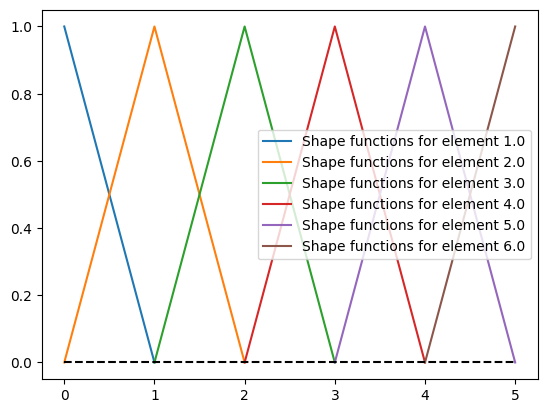

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def linear_lagrange_shape_function(total_length, num_nodes, node_x):
    l = total_length / (num_nodes - 1)
    node_number = (node_x / l) + 1

    if node_x == 0:
        x = np.array([node_x, node_x + l])
        y = np.array([1.0, 0.0])
    elif node_x == total_length:
        x = np.array([node_x - l, node_x])
        y = np.array([0.0, 1.0])
    else:
        x = np.array([node_x - l, node_x, node_x + l])
        y = np.array([0.0, 1.0, 0.0])

    return x, y, node_number

def plot_linear_lagrange_shape_functions(beam_length, num_nodes):

    x_positions = np.linspace(0, beam_length, num_nodes)
    for x_coords in x_positions:
        x, y, num = linear_lagrange_shape_function(beam_length, num_nodes, x_coords)
        plt.plot(x, y, label = f"Shape functions for element {num}")

    plt.plot(x_positions, np.zeros((len(x_positions))), ls = '--', color = 'black', markersize = 10)
    plt.legend()
    plt.legend()


# Example usage:
beam_length = 5.0  # Total length of the beam
num_nodes = 6     # Number of nodes along the beam
plot_linear_lagrange_shape_functions(beam_length, num_nodes)


In the finite element method, we substitute the discretized solution $u^h$ into the weak form equation. We are solving for $n$ values $u_i$. For this, we need to construct $n$ equations. Be reminded that with the "$\forall w$", we had an infinite number of equations. It turns out that it is useful to use the same shape functions $N_i(x)$ to pick $n$ relevant equations from this infinite set. We replace the $w(x)$ with its discretized counterpart $w^h(x)$:

$$ w^h(x) = \sum_{i=0}^{n-1}N_i(x)w_i $$

If the weak form has to hold for all possible functions $w^h$, this is equivalent to say that it has to hold for each of $w^h\in N_i$. So we construct the first equation by replacing $w$ with $N_0$, the second by replacing $w$ with $N_1$ and so until until equation $n$ with $N_{n-1}$. This gives:

$$ \int_{0}^{L} \frac{\partial N_i}{\partial x}EA \frac{\partial \left(\sum N_ju_j\right)}{\partial x}\,dx = \int_0^L N_iq\,dx$$

Because $u_j$ is not a function of $x$, it can be taken out of the integral to give:

$$ \sum_j \left(\left[ \int_{0}^{L} \frac{\partial N_i}{\partial x}EA \frac{\partial N_j}{\partial x}\,dx \right]u_j\right)= \int_0^L N_iq\,dx$$

or 

$$\mathbf{Ku} = \mathbf{f}$$

with 

$$K_{ij} = \int_{0}^{L} \frac{\partial N_i}{\partial x}EA \frac{\partial N_j}{\partial x}\,dx
\quad \text{and} \quad
f_i = \int_0^L N_iq\,dx$$

We still have a global integral and the product of all shape functions $N_i$ with all other shape functions $N_j$. However, we can make use of the fact that every individual shape function (and hence its derivatives) is equal to zero for the largest part of the domain. Moreover, we can split the integral in a sum of integrals over subdomains. Those subdomains are the **elements** of the finite element method. The element is a subdomain over which a fixed set of shape functions is active. For the case with linear shape functions, the element is defined as the domain between two neighboring nodes. We can then define the element stiffness matrix considering only those shape functions that are active in the element. 

```{figure} .././images/Chapter1/1_5_1.png
---
height: 200px
name: 1_5_1
---
Linear two-node element
```


If we introduce the $\mathbf{B}$ matrix (size $1\times 2$) to collect the derivatives of the shape functions in the element, we can write the element stiffness matrix as:

$$ \mathbf{K}_e = \int_{x_1}^{x_2} \mathbf{B}^T EA \mathbf{B} \,dx $$

where $x_1$ and $x_2$ are the $x$-coordinates of the two nodes of the element. For the 1D element with linear shape functions, $\mathbf{B}$ is defined as: 

$$\mathbf{B} = \left[\begin{matrix}\frac{-1}{\Delta x} & \frac{1}{\Delta x}\end{matrix}\right]$$

with $\Delta x = x_2-x_1$ Assuming a constant $EA$, evaluating the integrand over the element domain results in:

$$ \mathbf{K}_e = \frac{EA}{\Delta x}\left[\begin{matrix}1 & -1 \\ -1 & 1\end{matrix}\right]$$

### Implementation 

After working with individual elements with respect to the displacement of their nodes, the next step is to assemble a global matrix from contributions of every element. For this example the problem above is divided into three equal elements of $1$ meter. To stay organized we give each element and node a number. As you can see in the figure below, there are 4 nodes, numbered $n_0$ to $n_3$ and 3 elements numbered $e_0$ to $e_2$.

```{figure} .././images/Chapter1/1_2_2.png
---
height: 200px
name: 1_2_2
---
One dimensional multielement bar
```

In the physical interpretation of solving mechanical equilibrium in a bar, we can interpret the result of the product $\mathbf{K}_e\mathbf{u}$ as forces coming from the element. Using the "local" stiffness formulation as shown above we can acquire the forces exerted on a node by an element as a function of the displacement. We will in this example have four nodes and therefore four unknowns. Let us consider the forces excerted by the second element ($e2$):

$$
\left[\begin{matrix}f_1^{e2} \\ f_2^{e2} \\ f_3^{e2} \\ f_4^{e2}\end{matrix}\right] = \frac{EA}{\Delta x}\left[\begin{matrix}0 & 0 & 0 & 0 \\ 0 & 1 & -1 & 0 \\ 0 & -1 & 1 & 0 \\ 0 & 0 & 0 & 0 \end{matrix}\right] \left[\begin{matrix}u_1 \\ u_2 \\ u_3 \\ u_4\end{matrix}\right]
$$ (element2)

It follows logically that the other elements also excert forces on our nodes. By a simple addition of the influences of each element we can find the total stiffness matrix of our problem:


$$
\left[\begin{matrix}f_1 \\ f_2 \\ f_3 \\ f_4\end{matrix}\right] = \left[\begin{matrix}f_1^{e1} \\ f_2^{e1} \\ f_3^{e1} \\ f_4^{e1}\end{matrix}\right] + \left[\begin{matrix}f_1^{e2} \\ f_2^{e2} \\ f_3^{e2} \\ f_4^{e2}\end{matrix}\right] + \left[\begin{matrix}f_1^{e3} \\ f_2^{e3} \\ f_3^{e3} \\ f_4^{e3}\end{matrix}\right] = \frac{EA}{\Delta x} \left(\left[\begin{matrix}1 & -1 & 0 & 0 \\ -1 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{matrix}\right] + \left[\begin{matrix}0 & 0 & 0 & 0 \\ 0 & 1 & -1 & 0 \\ 0 & -1 & 1 & 0 \\ 0 & 0 & 0 & 0 \end{matrix}\right] + \left[\begin{matrix}0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & -1 \\ 0 & 0 & -1 & 1 \end{matrix}\right] \right) \left[\begin{matrix}u_1 \\ u_2 \\ u_3 \\ u_4\end{matrix}\right]
$$ (assembly)

Collection of the matrices gives:

$$
\left[\begin{matrix}f_1 \\ f_2 \\ f_3 \\ f_4\end{matrix}\right] = \frac{EA}{\Delta x}\left[\begin{matrix}1 & -1 & 0 & 0 \\ -1 & 2 & -1 & 0 \\ 0 & -1 & 2 & -1 \\ 0 & 0 & -1 & 1 \end{matrix}\right] \left[\begin{matrix}u_1 \\ u_2 \\ u_3 \\ u_4\end{matrix}\right]
$$ (sumofmatrixes)

To solve for global equilibrium, we need to equate the product $\mathbf{Ku}$ to a vector with external forces. Point loads on a node can directly be inserted on the right hand side vector of the equation $\mathbf{Ku}=\mathbf{f}$, while a distributed load $q$ is translated to a load vector with the expression from the derivation:

$$
\mathbf{f}=\int_0^L\mathbf{N}^Tq\,dx
$$ (distributedload)

### Boundary conditions

We derived a way to express the relation between $\mathbf{u}$ and $\mathbf{f}$ through a matrix $\mathbf{K}$. However, when we try to solve the equation $\mathbf{K u} = \mathbf{f}$, we will run into a problem. On the left hand side one of the values for $u$ is already known, the displacement of the left node ($n_0$) will be zero. The corresponding force $f_1$ is as of yet unknown. Since there is unknowns on either side of the equation we cannot solve it by inverting K and bringing it to the other side.

$$
\frac{EA}{\Delta x}\left[\begin{matrix}1 & -1 & 0 & 0 \\ -1 & 2 & -1 & 0 \\ 0 & -1 & 2 & -1 \\ 0 & 0 & -1 & 1 \end{matrix}\right] \left[\begin{matrix}0 \\ u_2? \\ u_3? \\ u_4?\end{matrix}\right] = \left[\begin{matrix}f_1? \\ 0 \\ 0 \\ 10\end{matrix}\right]
$$ (totalmatrix)

A way to overcome this problem is to leave out equations belonging to nodes for which the solution is known. As long as the fixed degrees of freedom are prescribed at a value of 0 (i.e. homogeneous Dirichlet conditions), we can do this by simply removing the corresponding columns and rows out of our system. Doing that for node 0 in our example, we get:

$$
\frac{EA}{\Delta x}\left[\begin{matrix} 2 & -1 & 0 \\ -1 & 2 & -1 \\ 0 & -1 & 1 \end{matrix}\right] \left[\begin{matrix}u_2? \\ u_3? \\ u_4?\end{matrix}\right] = \left[\begin{matrix}0 \\ 0 \\ 10\end{matrix}\right]
$$ (totalmatrix_afterbcs)

This system can solved, by inverting $\mathbf{K}$, or more efficiently by using an appropriate linear solver. It is important to note that for nonzero Dirichlet conditions, additional steps need to be taken.

Solving the system of equations above will finally result in a vector with values for the nodal displacements $\mathbf{u}$. Note that with the shape functions, we also have an interpolation between the nodes, so a continuous approximate solution $u^h(x)$ can be obtained with:

$$
u^h(x) = \mathbf{N}\mathbf{u}
$$ (continuoussolution)

Moreover, the reaction force $f_1$ can be computed by multiplying the complete $4\times4$-matrix with the nodal displacement vector.


In [24]:
import numpy as np

def elastic_rod(total_length, EA, num_nodes, force):

    # Define element length
    element_length = total_length / (num_nodes - 1)

    # Assemble local stiffness matrix
    k_local = (EA / element_length) * np.array([[1, -1], [-1, 1]])

    # Assemble global stiffness matrix (for simplicity, assume one element)
    K_global = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes - 1):
        K_global[i:i+2, i:i+2] += k_local

    # Define boundary conditions (left side set to zero displacement)
    bc_nodes = [0]

    # Apply boundary conditions
    for i in bc_nodes:
        K_global[i, :] = 0
        K_global[:, i] = 0
        K_global[i, i] = 1

    # Define external forces (for example, f[3] = 10)
    external_forces = np.zeros(num_nodes)
    external_forces[-1] = force

    # Solve the system of equations Ku = f
    u = np.linalg.solve(K_global, external_forces)
    return u

ds = elastic_rod(total_length = 3.0, EA = 1.0, num_nodes = 20, force = 20)
print(ds)

[ 0.          3.15789474  6.31578947  9.47368421 12.63157895 15.78947368
 18.94736842 22.10526316 25.26315789 28.42105263 31.57894737 34.73684211
 37.89473684 41.05263158 44.21052632 47.36842105 50.52631579 53.68421053
 56.84210526 60.        ]
